In [1]:
import matplotlib
matplotlib.use('nbagg')
from scipy import ndimage
import numpy as np
import pickle
import fish_track as ft
import fish_3d as f3
import configparser
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.image import NonUniformImage
from importlib import reload
from scipy import optimize
import itertools
from scipy.spatial.distance import cdist
import ipyvolume as ipv
import yaggie

%load_ext autoreload
%autoreload 2

In [2]:
def get_gr(positions, cutoff, bins, minimum_gas_number=1e4):
    box_size = np.max(positions, 0) - np.min(positions, 0)
    box_volume = box_size[0] * box_size[1] * box_size[2]
    bins = np.linspace(0, cutoff, bins)
    drs = bins[1:] - bins[:-1]
    shell_volume = 4 * np.pi * drs**2
    distances = pdist(positions).ravel()
    hist, _ = np.histogram(distances, bins=bins, density=False)
    hist = hist / positions.shape[0]
    hist = hist / shell_volume
    centres = (bins[1:] + bins[:-1]) / 2
    return centres, hist


def is_inbox(position, box):
    is_inside = True
    for dim in range(len(position)):
        is_inside *= position[dim] > box[dim].start
        is_inside *= position[dim] < box[dim].stop
    return is_inside


def get_volume_from_box(box):
    volume = 1
    for dim in range(len(box)):
        volume *= box[dim].stop - box[dim].start
    return volume


def get_gr_inbox(positions, cutoff, bins, box):
    new_positions = []
    for p in positions:
        if is_inbox(p, box):
            new_positions.append(p)
    new_positions = np.array(new_positions)
    bins = np.linspace(0, cutoff, bins)
    drs = bins[1:] - bins[:-1]
    distances = pdist(new_positions).ravel()
    volume = get_volume_from_box(box)
    if new_positions.shape[0] < 1e4:
        rg_hists = []
        for i in range(int(1e4) // new_positions.shape[0] + 2):
            random_gas = np.random.random(new_positions.shape) * volume ** (1 / 3)
            rg_hist = np.histogram(pdist(random_gas), bins=bins)[0]
            rg_hists.append(rg_hist)
        rg_hist = np.mean(rg_hists, 0)
    else:
        random_gas = np.random.random(new_positions.shape) * volume ** (1 / 3)
        rg_hist = np.histogram(pdist(random_gas), bins=bins)[0]
    hist = np.histogram(distances, bins=bins)[0]
    hist = hist / rg_hist
    hist[np.isnan(hist)] = 0
    centres = (bins[1:] + bins[:-1]) / 2
    return centres, hist

In [3]:
frames = 150
locations = []
for i in range(0, frames):
    pos = np.load(f'../stereo_done/location_3d_frame_{i:04}.npy')
    locations.append(pos)

In [6]:
linker = yaggie.track.TrackpyEngine(max_movement=30, memory=3)
trajectories = linker.run(locations, time_points = np.arange(frames))
trajectories = [t for t in trajectories if len(t['position']) > 1]

print(len(trajectories))

with open('vanilla_trajectories.pkl', 'wb') as f:
    pickle.dump(trajectories, f)

Frame 149: 5 trajectories present.
5


<IPython.core.display.Javascript object>


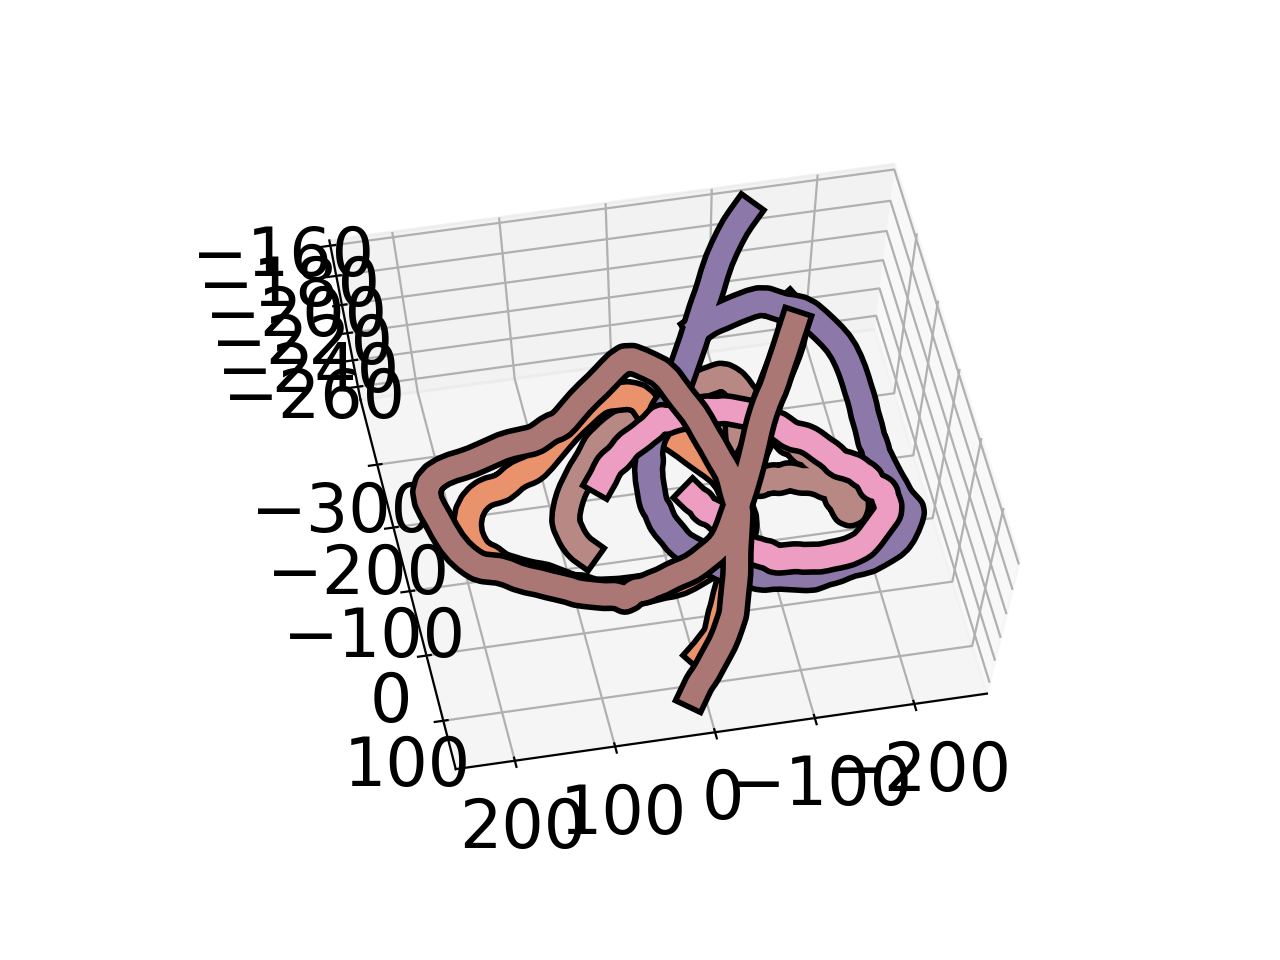

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for t in trajectories:
    signal = np.array(t['position']).T
    signal = ndimage.gaussian_filter1d(signal, 1, axis=1)
    adjust = np.array((1.0, 0.5, 0.8))
    ax.plot(*signal, lw=12, color='k')
    ax.plot(*signal, lw=8, color=np.random.random(3) * (1 - adjust / 16) / 2 +  adjust / 2)
ax.view_init(elev=65, azim=45)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax.zaxis.get_major_ticks():
    tick.label.set_fontsize(24)
#plt.xlabel('X (mm)', fontsize=32, labelpad=32)
#plt.ylabel('Y (mm)', fontsize=32, labelpad=32)
#ax.set_zlabel('Z (mm)', fontsize=32, labelpad=32)
#fig.set_size_inches(15, 15)
#plt.savefig('traj_3d.pdf')
plt.show()
plt.close()

[ -77.90557418   32.63948492 -270.68921938] 58.224953490715315


<IPython.core.display.Javascript object>


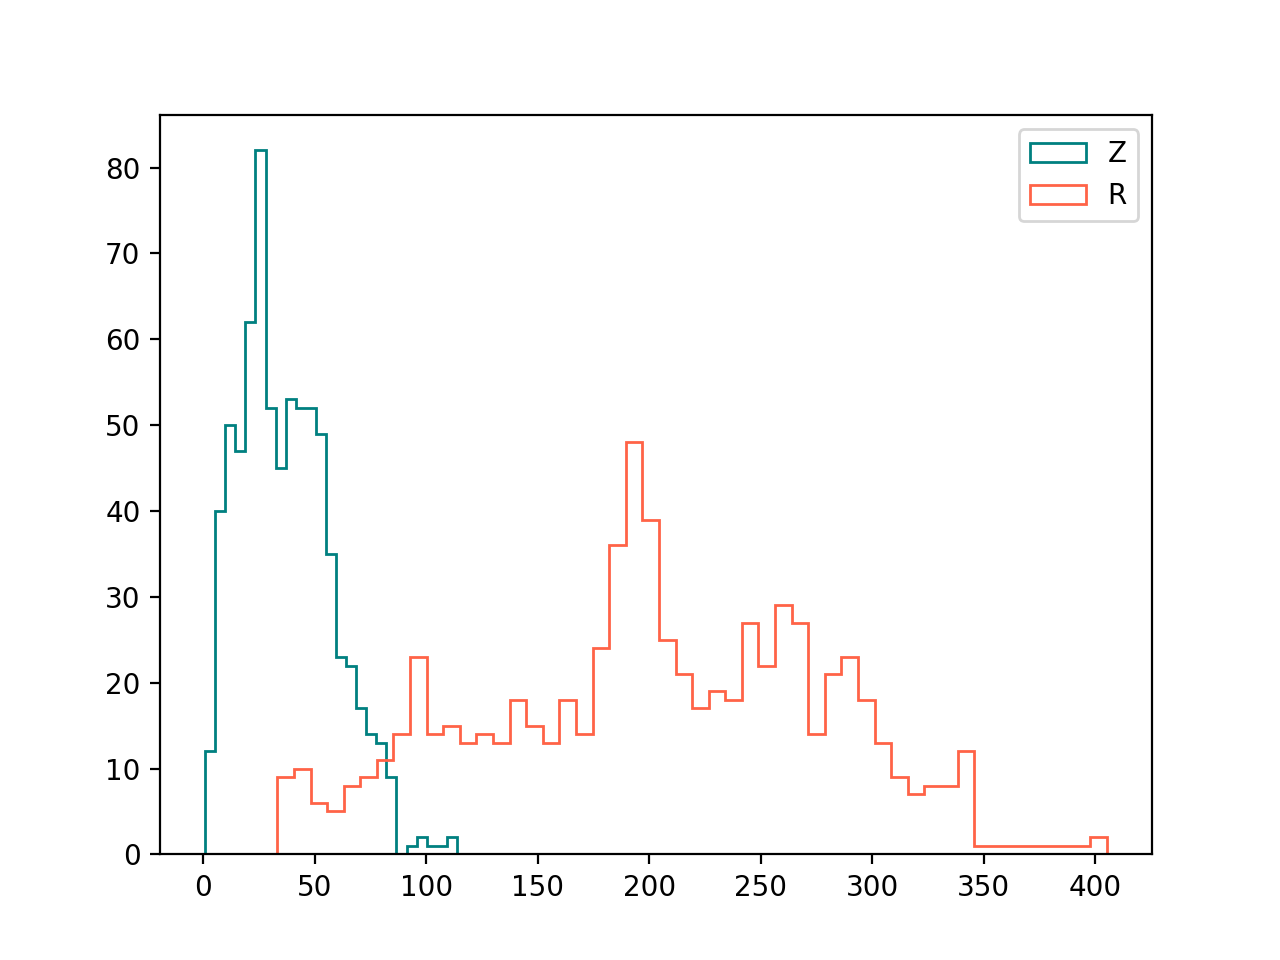

In [8]:
cameras = []
for i in range(1, 4):
    with open(f'camera_{i}.pkl', 'rb') as f:
        cameras.append(pickle.load(f))
origins_mv = np.array([[738, 989], [744, 923], [787, 1064]])  # measured manually from FIJI

origin, err = f3.ray_trace.ray_trace_refractive_faster(origins_mv, cameras)
print(origin, err)

frames = 150
locations = np.empty((0, 3))

for t in trajectories:
    pos = t['position']
    locations = np.concatenate([locations, pos])
    
dz = locations[:, -1] - origin[-1]
dr = np.linalg.norm(locations[:, :2] - origin[:2], axis=1)
plt.hist(dz, bins=25, histtype='step', color='teal', label='Z')
plt.hist(dr, bins=50, histtype='step', color='tomato', label='R')
plt.legend()
plt.savefig('spatial_dist.pdf')
plt.show()

<IPython.core.display.Javascript object>


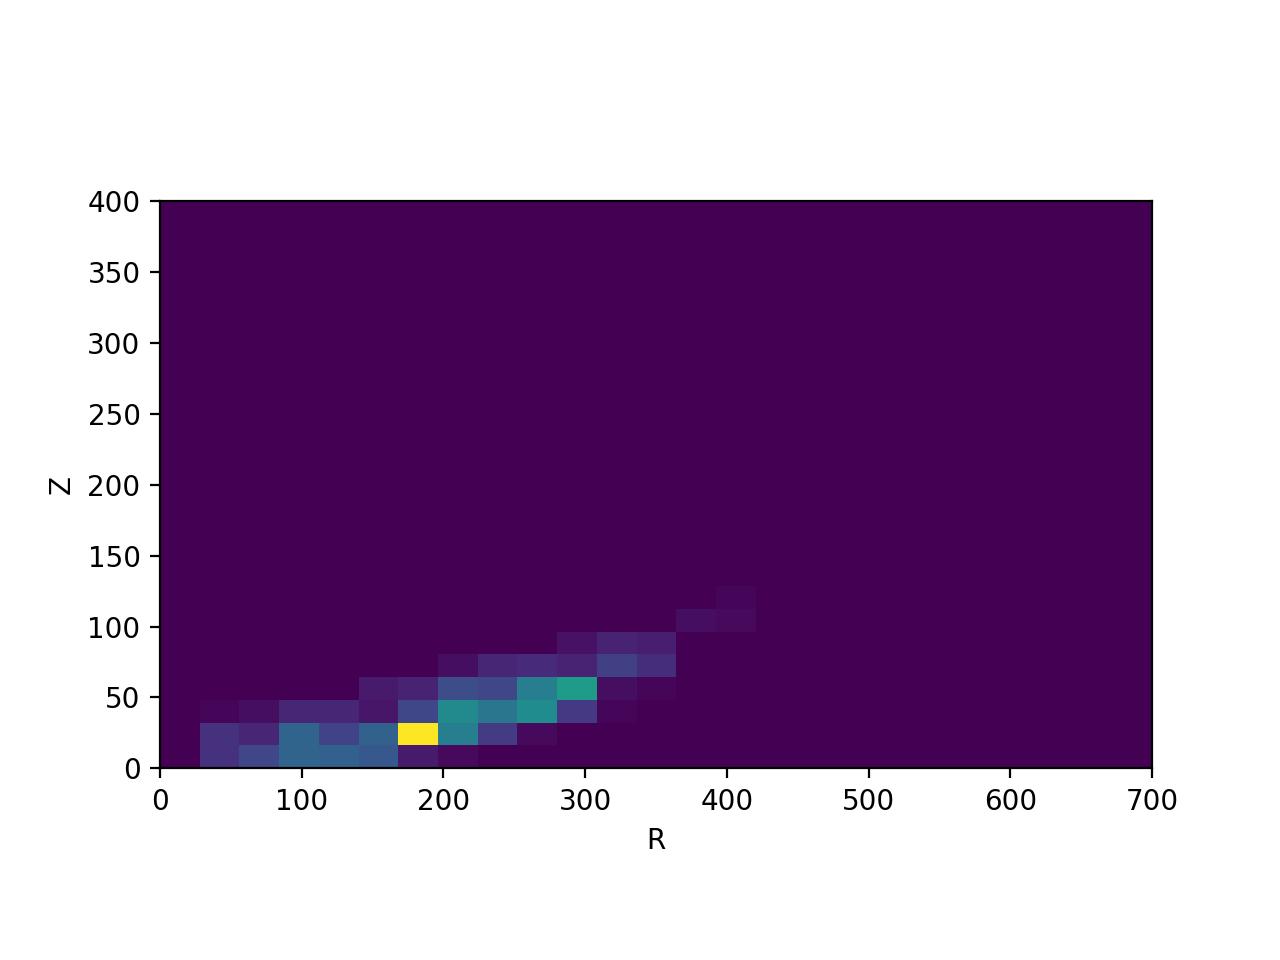

In [9]:
hist_2d, x_edges, y_edges  = np.histogram2d(
    dz, dr, bins=(25, 25), range=((0, 400), (0, 700))
)

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', ylim=x_edges[[0, -1]], xlim=y_edges[[0, -1]])

x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
im = NonUniformImage(ax, interpolation='nearest')

im.set_data(y_centers, x_centers, hist_2d)
ax.images.append(im)
ax.set_xlabel('R')
ax.set_ylabel('Z')

plt.savefig('spatial_dist_2d.pdf')

plt.show()